# Kuramoto-Sivashinsky Equation - Refactored

SHRED-ROM for the Kuramoto-Sivashinsky equation with JAX/Equinox.

This notebook uses modular utility scripts for:
- Data processing (`utils/ks_data_processing.py`)
- Visualization (`utils/ks_visualization.py`)
- Model tracking (`utils/mlflow_utils.py`)

In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
import importlib

# Local utilities - with reload to pick up changes
import utils.ks_data_processing
import utils.ks_visualization
import utils.mlflow_utils
import utils.models_diffrax

importlib.reload(utils.ks_data_processing)
importlib.reload(utils.ks_visualization)
importlib.reload(utils.mlflow_utils)
importlib.reload(utils.models_diffrax)

from utils.ks_data_processing import KSDataset, rmse, mre, compute_state
from utils.ks_visualization import (
    plot_state, plot_mode, plot_singular_values, plot_training_curves,
    plot_comparison, multiplot, create_trajectory_animation,
    create_comparison_animation, plot_model_comparison, plot_snapshot_comparison
)
from utils.mlflow_utils import ModelTracker, load_model
from utils.models_diffrax import SHRED, NeuralCDE, fit_SHRED, fit_CDE

plt.style.use('default')
print("Imports complete!")

MLflow not installed. Using local file-based tracking.
MLflow not installed. Using local file-based tracking.
Imports complete!


## 1. Configuration

In [2]:
# CONFIGURATION
CONFIG = {
    # Data parameters
    'data_file': 'KuramotoSivashinsky_data',
    'ntrajectories': 100,  # Number of trajectories to use
    'train_ratio': 0.8,
    
    # Domain parameters
    'L': 22,
    'nstate': 100,
    'dt': 1e-2,
    'T': 200.0,
    'nstepsoutput': 200,
    
    # POD parameters
    'kstate': 20,  # Number of POD modes
    
    # SHRED parameters
    'nsensors': 3,
    'idx_sensors': [25, 50, 75],
    'lag': 10,  # Smaller lag for faster training
    
    # Training parameters
    'batch_size': 64,
    'epochs': 200,  # Reduced for testing
    'lr': 1e-3,
    'patience': 40,
    'hidden_size': 64,
    'hidden_layers': 2,
    'decoder_sizes': [350, 400],
    
    # Misc
    'seed': 0,
    'experiment_name': 'ks_shred_experiment'
}

print("Configuration loaded!")

Configuration loaded!


## 2. Load Data

In [3]:
# LOAD DATA AND PREPARE DATASETS
dataset = KSDataset(
    filename=CONFIG['data_file'],
    ntrajectories=CONFIG['ntrajectories'],
    train_ratio=CONFIG['train_ratio'],
    kstate=CONFIG['kstate'],
    lag=CONFIG['lag'],
    idx_sensors=CONFIG['idx_sensors'],
    L=CONFIG['L'],
    nstate=CONFIG['nstate'],
    dt=CONFIG['dt'],
    T=CONFIG['T'],
    seed=CONFIG['seed']
)

# Get SHRED datasets
shred_data = dataset.get_shred_datasets()
train_data = shred_data['train']
valid_data = shred_data['valid']
test_data = shred_data['test']

# Get CDE datasets
cde_data = dataset.get_cde_datasets()

print(f"Dataset loaded:")
print(f"  Trajectories: {dataset.ntrajectories} (train={dataset.ntrain}, valid={dataset.nvalid}, test={dataset.ntest})")
print(f"  Time steps: {dataset.ntimes}, State dim: {dataset.nstate}, POD modes: {dataset.kstate}")
print(f"  Sensors: {dataset.nsensors} at {dataset.idx_sensors}, Lag: {dataset.lag}")
print(f"\nSHRED data: {train_data['S_i'].shape[0]} train, {valid_data['S_i'].shape[0]} valid, {test_data['S_i'].shape[0]} test")
print(f"CDE data:   {cde_data['train']['ts'].shape[0]} train, {cde_data['valid']['ts'].shape[0]} valid, {cde_data['test']['ts'].shape[0]} test")

Dataset loaded:
  Trajectories: 100 (train=80, valid=10, test=10)
  Time steps: 201, State dim: 100, POD modes: 20
  Sensors: 3 at [25, 50, 75], Lag: 10

SHRED data: 16080 train, 2010 valid, 2010 test
CDE data:   15280 train, 1910 valid, 1910 test


## 3. Define Models

In [4]:
# CREATE MODELS
model_key = jr.PRNGKey(CONFIG['seed'])
input_size = dataset.nsensors
output_size = dataset.kstate

# SHRED Model
shred_model = SHRED(
    input_size=input_size,
    output_size=output_size,
    hidden_size=CONFIG['hidden_size'],
    hidden_layers=CONFIG['hidden_layers'],
    decoder_sizes=CONFIG['decoder_sizes'],
    activation=jax.nn.relu,
    key=model_key
)

# Neural CDE Model
cde_key = jr.PRNGKey(42)
cde_data_size = cde_data['train']['ys'].shape[-1]
cde_hidden_size = 64
cde_width_size = 64
cde_depth = 2
cde_decoder_sizes = [350, 400]

cde_model = NeuralCDE(
    data_size=cde_data_size,
    hidden_state=cde_hidden_size,
    width_size=cde_width_size,
    depth=cde_depth,
    activation_cde=jax.nn.tanh,
    activation_decoder=jax.nn.tanh,
    output_size=output_size,
    decoder_sizes=cde_decoder_sizes,
    key=cde_key
)

print("Models created:")
print(f"  SHRED:      input={input_size}, hidden={CONFIG['hidden_size']}, output={output_size}")
print(f"  Neural CDE: data_size={cde_data_size}, hidden={cde_hidden_size}, output={output_size}")

Models created:
  SHRED:      input=3, hidden=64, output=20
  Neural CDE: data_size=3, hidden=64, output=20


## 4. Train Models (or Load Pretrained)

In [6]:
# TRAIN MODELS (set LOAD_PRETRAINED=True to skip training)
LOAD_PRETRAINED = False  # Set to True to load saved models instead of training

if LOAD_PRETRAINED:
    # Load pretrained models (you need to have saved them first)
    import pickle
    print("Loading pretrained models...")
    # Uncomment and adjust path as needed:
    # with open('saved_models/shred_model.pkl', 'rb') as f:
    #     shred_model = pickle.load(f)
    # with open('saved_models/cde_model.pkl', 'rb') as f:
    #     cde_model = pickle.load(f)
    print("Models loaded!")
else:
    # Train SHRED
    print("Training SHRED model...")
    shred_model, train_losses_shred, valid_losses_shred = fit_SHRED(
        shred_model, train_data, valid_data,
        batch_size=CONFIG['batch_size'], epochs=CONFIG['epochs'],
        lr=CONFIG['lr'], early_stopping=CONFIG['patience'],
        seed=CONFIG['seed'], verbose=True
    )
    print(f"SHRED done: train={train_losses_shred[-1]:.4e}, valid={valid_losses_shred[-1]:.4e}\n")
    
    # Train Neural CDE
    cde_train_data = {
        'ts': jnp.array(cde_data['train']['ts']),
        'coeffs': tuple(jnp.array(c) for c in cde_data['train']['coeffs']),
        'Y': jnp.array(cde_data['train']['Y'])
    }
    cde_valid_data = {
        'ts': jnp.array(cde_data['valid']['ts']),
        'coeffs': tuple(jnp.array(c) for c in cde_data['valid']['coeffs']),
        'Y': jnp.array(cde_data['valid']['Y'])
    }
    
    print("\nTraining Neural CDE...")
    cde_model, cde_train_losses, cde_valid_losses = fit_CDE(
        model=cde_model, train_data=cde_train_data, valid_data=cde_valid_data,
        epochs=CONFIG['epochs'], batch_size=CONFIG['batch_size'], lr=CONFIG['lr'], early_stopping=CONFIG['patience']
    )
    print(f"CDE done: train={cde_train_losses[-1]:.4e}, valid={cde_valid_losses[-1]:.4e}")

Training SHRED model...
Epoch 200/200 | Train 1.0393e-03 | Valid 2.0179e-02 | Time 1.19s | Patience 9/400
Training done: Train loss = 1.0393e-03 | Valid loss = 2.0179e-02
SHRED done: train=1.0393e-03, valid=2.0179e-02


Training Neural CDE...
Epoch 200/200 | Train 4.3822e-03 | Valid 3.3016e-02 | Time 20.70s | Patience 1/400
Training done: Train loss = 4.3822e-03 | Valid loss = 3.3016e-02
CDE done: train=4.3822e-03, valid=3.3016e-02


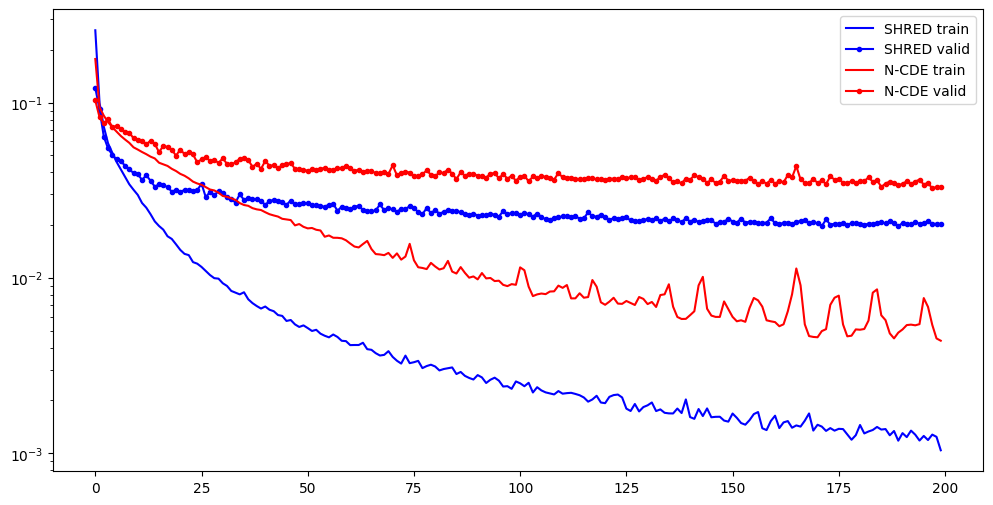

In [7]:
plt.figure(figsize=(12,6))

plt.plot(train_losses_shred, 'b-', label = 'SHRED train')
plt.plot(valid_losses_shred, 'b.-', label = 'SHRED valid')
plt.plot(cde_train_losses, 'r-', label = 'N-CDE train')
plt.plot(cde_valid_losses, 'r.-', label = 'N-CDE valid')
plt.yscale('log')
plt.legend()

## 5. Measure Errors

In [8]:
# EVALUATE MODELS ON TEST SET

# SHRED predictions
test_pred_pod = jax.vmap(shred_model)(test_data['S_i'])
test_pred_full = dataset.inverse_transform_pod(np.array(test_pred_pod))
test_pred_full = test_pred_full.reshape(dataset.ntest, dataset.ntimes, dataset.nstate)
shred_mre_pod = mre(test_data['Y'], np.array(test_pred_pod))
shred_test_true_full = dataset.inverse_transform_pod(test_data['Y'])
shred_mre_full = mre(shred_test_true_full, dataset.inverse_transform_pod(np.array(test_pred_pod)))

# Neural CDE predictions
cde_test_data = {
    'ts': jnp.array(cde_data['test']['ts']),
    'coeffs': tuple(jnp.array(c) for c in cde_data['test']['coeffs']),
    'Y': jnp.array(cde_data['test']['Y'])
}
cde_test_pred_pod = jax.vmap(cde_model)(cde_test_data['ts'], cde_test_data['coeffs'])
cde_test_pred_pod_np = np.array(cde_test_pred_pod)
cde_mre_pod = mre(cde_data['test']['Y'], cde_test_pred_pod_np)
cde_test_pred_full = dataset.inverse_transform_pod(cde_test_pred_pod_np)
cde_test_true_full = dataset.inverse_transform_pod(cde_data['test']['Y'])
cde_mre_full = mre(cde_test_true_full, cde_test_pred_full)

# Print comparison
print("=" * 60)
print("MODEL COMPARISON - Kuramoto-Sivashinsky")
print("=" * 60)
print(f"\n{'Metric':<30} {'SHRED':>12} {'Neural CDE':>12}")
print("-" * 60)
print(f"{'Test MRE (POD space)':<30} {shred_mre_pod*100:>11.2f}% {cde_mre_pod*100:>11.2f}%")
print(f"{'Test MRE (Full state)':<30} {shred_mre_full*100:>11.2f}% {cde_mre_full*100:>11.2f}%")
print("=" * 60)

MODEL COMPARISON - Kuramoto-Sivashinsky

Metric                                SHRED   Neural CDE
------------------------------------------------------------
Test MRE (POD space)                  5.64%        7.66%
Test MRE (Full state)                16.09%       22.06%


## 6. Animation: Ground Truth vs SHRED vs Neural CDE

Saved: ks_comparison.gif


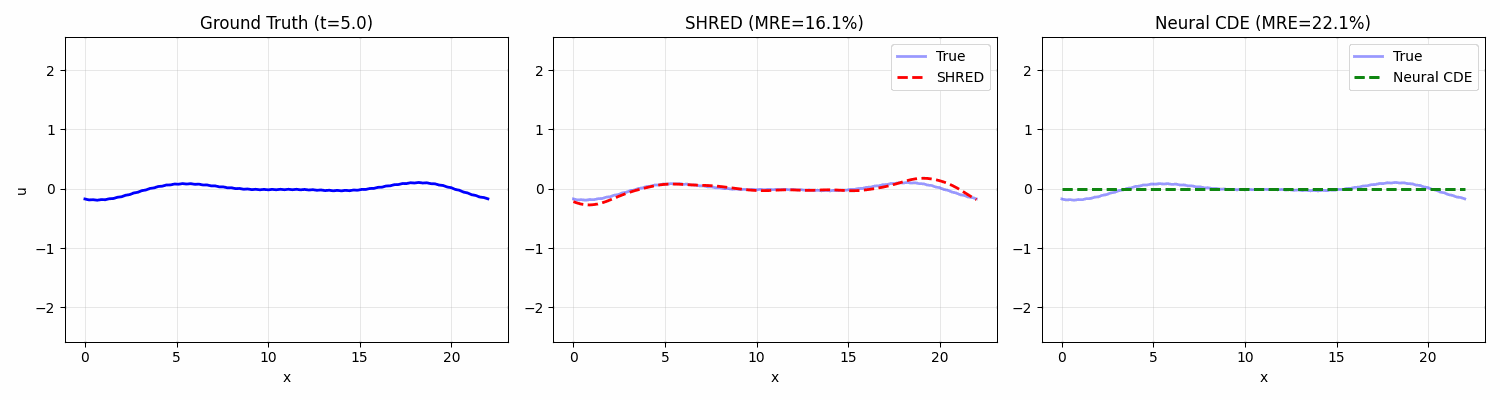

In [9]:
# ANIMATION: GROUND TRUTH vs SHRED vs NEURAL CDE
from IPython.display import Image
import imageio
import io
from PIL import Image as PILImage

# Select trajectory
which = 0

# Prepare CDE predictions to match trajectory structure
n_windows_per_traj = dataset.ntimes - dataset.lag
cde_traj_pred = cde_test_pred_full[:n_windows_per_traj]
cde_pred_padded = np.zeros_like(dataset.Utest[which])
cde_pred_padded[dataset.lag:] = cde_traj_pred

def create_triple_comparison(true_state, shred_pred, cde_pred, x, T,
                              shred_mre, cde_mre, step=5, filename="comparison.gif", fps=10):
    """Animation comparing ground truth, SHRED, and Neural CDE."""
    ntimes = true_state.shape[0]
    time_per_step = T / ntimes
    
    frames = []
    for t_idx in range(max(2, step), ntimes, step):
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        t = t_idx * time_per_step
        ylim = [true_state.min()-0.5, true_state.max()+0.5]
        
        # Ground Truth
        axes[0].plot(x, true_state[t_idx], 'b-', lw=2)
        axes[0].set_title(f'Ground Truth (t={t:.1f})')
        axes[0].set_ylim(ylim); axes[0].grid(True, alpha=0.3)
        axes[0].set_xlabel('x'); axes[0].set_ylabel('u')
        
        # SHRED
        axes[1].plot(x, true_state[t_idx], 'b-', lw=2, alpha=0.4, label='True')
        axes[1].plot(x, shred_pred[t_idx], 'r--', lw=2, label='SHRED')
        axes[1].set_title(f'SHRED (MRE={shred_mre*100:.1f}%)')
        axes[1].set_ylim(ylim); axes[1].grid(True, alpha=0.3); axes[1].legend()
        axes[1].set_xlabel('x')
        
        # Neural CDE
        axes[2].plot(x, true_state[t_idx], 'b-', lw=2, alpha=0.4, label='True')
        axes[2].plot(x, cde_pred[t_idx], 'g--', lw=2, label='Neural CDE')
        axes[2].set_title(f'Neural CDE (MRE={cde_mre*100:.1f}%)')
        axes[2].set_ylim(ylim); axes[2].grid(True, alpha=0.3); axes[2].legend()
        axes[2].set_xlabel('x')
        
        plt.tight_layout()
        
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100)
        buf.seek(0)
        frames.append(PILImage.open(buf).copy())
        buf.close()
        plt.close(fig)
    
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=1000//fps, loop=0)
    print(f"Saved: {filename}")
    return Image(filename=filename)

# Create the animation
gif = create_triple_comparison(
    true_state=dataset.Utest[which],
    shred_pred=test_pred_full[which],
    cde_pred=cde_pred_padded,
    x=dataset.x,
    T=CONFIG['T'],
    shred_mre=shred_mre_full,
    cde_mre=cde_mre_full,
    step=5,
    filename="ks_comparison.gif",
    fps=10
)
gif